In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import torch.nn as nn
import torch
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import random
from torch.amp import autocast, GradScaler
from torchvision.models import vit_b_16, ViT_B_16_Weights

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"

def set_global_seed(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

    try:
        import cv2
        cv2.setRNGSeed(seed)
    except:
        pass

set_global_seed(42)

In [2]:
class CustomDataset(Dataset):
    """ 
    Custom Dataset that loads all pictures into the memory at the start.
    """
    def __init__(self, root):
        self.class_names = sorted(os.listdir(root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        self.paths = sorted(glob(f"{root}/*/*"))

        print("Loading in ram...")
        self.images = []
        self.labels = []

        for i, path in enumerate(self.paths):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_name = os.path.basename(os.path.dirname(path))
            label = self.class_to_idx[label_name]

            self.images.append(img)
            self.labels.append(label)

            if i % 500 == 0:
                print(f"{i}/{len(self.paths)} pictures loaded...")

        print(f"Loading completed. {len(self.images)} pictures loaded.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

root = os.path.join("Lung X-Ray Image", "Lung X-Ray Image")

dataset = CustomDataset(root)

total = len(dataset)
test_size = int(0.15 * total)
val_size = int(0.15 * total)
train_size = total - val_size - test_size

train_base, val_base, test_base = random_split(dataset, [train_size, val_size, test_size])

num_classes = len(dataset.class_names)

Loading in ram...
0/3319 pictures loaded...
500/3319 pictures loaded...
1000/3319 pictures loaded...
1500/3319 pictures loaded...
2000/3319 pictures loaded...
2500/3319 pictures loaded...
3000/3319 pictures loaded...
Loading completed. 3319 pictures loaded.


In [3]:
class TransformDataset(Dataset):
    """" 
    This wrapper applies transformations on-the-fly to the existing dataset.
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
def train_one_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        with autocast(device):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.detach()

    return (running_loss / len(loader)).item()


def validate(model, loader, criterion, device):
    model.eval()
    total_correct = 0
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast(device):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.detach()
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum()
            total_samples += labels.size(0)

    avg_loss = (running_loss / len(loader)).item()
    accuracy = (total_correct / total_samples).item()
    
    return avg_loss, accuracy

In [5]:
class CLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=0.5):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            if isinstance(img, torch.Tensor):
                img_np = img.permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = np.array(img)
            
            clahe = cv2.createCLAHE(
                clipLimit=self.clip_limit,
                tileGridSize=self.tile_grid_size
            )
            
            if len(img_np.shape) == 3:
                img_clahe = np.zeros_like(img_np)
                for i in range(img_np.shape[2]):
                    img_clahe[:, :, i] = clahe.apply(img_np[:, :, i])
            else:
                img_clahe = clahe.apply(img_np)
            
            img = torch.from_numpy(img_clahe).float() / 255.0
            if len(img_clahe.shape) == 3:
                img = img.permute(2, 0, 1)
        
        return img

class GaussianNoise:
    def __init__(self, mean=0.0, std=0.02, p=0.3):
        self.mean = mean
        self.std = std
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            noise = torch.randn_like(img) * self.std + self.mean
            img = img + noise
            img = torch.clamp(img, 0.0, 1.0)
        return img

class RandomGamma:
    def __init__(self, gamma_range=(0.8, 1.2), p=0.5):
        self.gamma_range = gamma_range
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            gamma = random.uniform(*self.gamma_range)
            img = torch.pow(img, gamma)
        return img

# Fine tuning pretrained vit

In [6]:
train_transform = T.Compose([
    CLAHE(clip_limit=2.5, tile_grid_size=(8, 8), p=0.6),
    T.ColorJitter(brightness=0.25, contrast=0.25),
    RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
    GaussianNoise(mean=0.0, std=0.02, p=0.3),
    T.Normalize(mean=[0.5], std=[0.5]),
    T.Resize((224, 224))
])

val_transform = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5]),
    T.Resize((224, 224))
])

test_transform = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5]),
    T.Resize((224, 224))
])

train_dataset = TransformDataset(train_base, transform=train_transform)
val_dataset   = TransformDataset(val_base,   transform=val_transform)
test_dataset  = TransformDataset(test_base,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=2*64, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=2*64, shuffle=False, num_workers=0, pin_memory=True)

In [12]:
if device == 'cuda':
    torch.cuda.empty_cache()

# Model
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

for param in model.parameters():
    param.requires_grad = False

in_features = model.heads.head.in_features
model.heads.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Warmup trainable params: {trainable_params}")


## Training
train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float("inf")

# Warmup
warmup_epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer_warmup = torch.optim.AdamW(model.heads.head.parameters(), lr=1e-4, weight_decay=0.01)
scaler = torch.amp.GradScaler('cuda')

for epoch in range(warmup_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer_warmup, device, scaler)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/pretrained_vit.pth")
        print(f"Warmup Epoch {epoch+1}/{warmup_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}| New best saved.")
    else:
        print(f"Warmup Epoch {epoch+1}/{warmup_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

# Finetuning
finetuning_epochs = 50

for param in model.encoder.layers[-2:].parameters():
    param.requires_grad = True

for param in model.encoder.ln.parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Finetuning trainable params: {trainable_params}")

optimizer_ft = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-5, 
    weight_decay=0.05
)

scheduler_ft = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=finetuning_epochs)

for epoch in range(finetuning_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer_ft, device, scaler)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler_ft.step()
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/pretrained_vit.pth")
        print(f"Finetuning Epoch {epoch+1}/{finetuning_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, LR={scheduler_ft.get_last_lr()[0]:.6f}| New best saved.")
    else:
        print(f"Finetuning Epoch {epoch+1}/{finetuning_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, LR={scheduler_ft.get_last_lr()[0]:.6f}")
        

if device == 'cuda':
    torch.cuda.empty_cache()

Warmup trainable params: 2307
Warmup Epoch 1/5: train_loss=1.0549, val_loss=0.9200, val_acc=0.6419| New best saved.
Warmup Epoch 2/5: train_loss=0.9629, val_loss=0.8326, val_acc=0.7726| New best saved.
Warmup Epoch 3/5: train_loss=0.8768, val_loss=0.7602, val_acc=0.7787| New best saved.
Warmup Epoch 4/5: train_loss=0.8048, val_loss=0.7016, val_acc=0.8089| New best saved.
Warmup Epoch 5/5: train_loss=0.7376, val_loss=0.6543, val_acc=0.8189| New best saved.
Finetuning trainable params: 14179587
Finetuning Epoch 1/50: train_loss=0.6296, val_loss=0.5116, val_acc=0.8310, LR=0.000010| New best saved.
Finetuning Epoch 2/50: train_loss=0.5015, val_loss=0.4279, val_acc=0.8551, LR=0.000010| New best saved.
Finetuning Epoch 3/50: train_loss=0.4327, val_loss=0.3848, val_acc=0.8551, LR=0.000010| New best saved.
Finetuning Epoch 4/50: train_loss=0.3868, val_loss=0.3529, val_acc=0.8652, LR=0.000010| New best saved.
Finetuning Epoch 5/50: train_loss=0.3652, val_loss=0.3325, val_acc=0.8712, LR=0.000010

### Learning curves

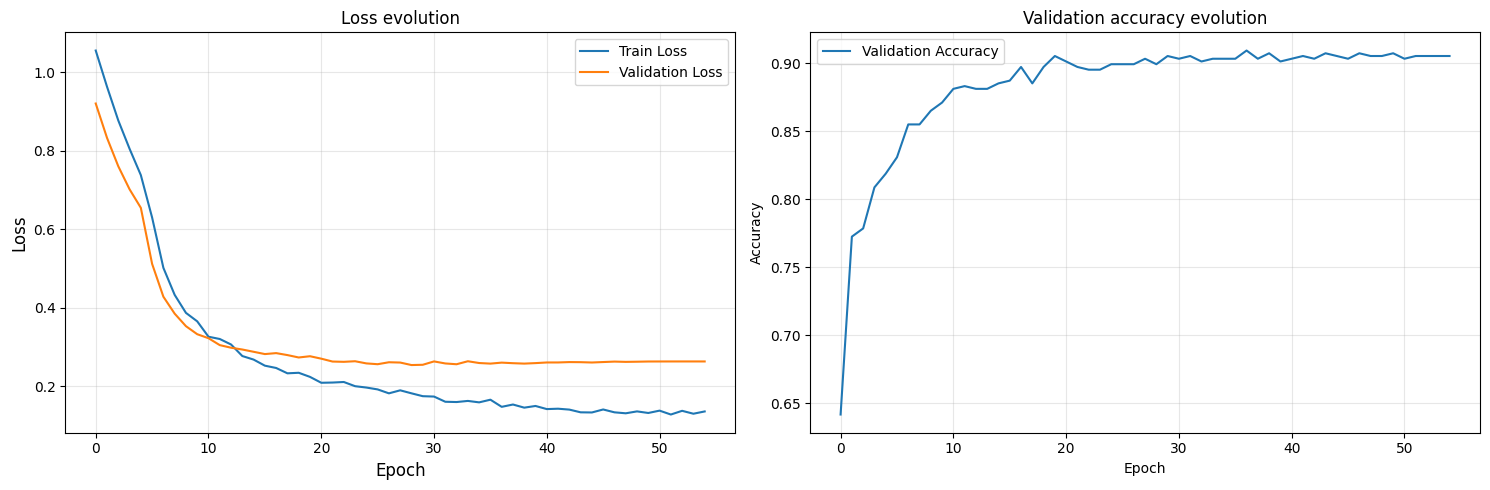

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation accuracy evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation

In [14]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

test_loader  = DataLoader(test_dataset,  batch_size=2*64, shuffle=False, num_workers=0, pin_memory=True)

weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

in_features = model.heads.head.in_features
model.heads.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)
model.load_state_dict(torch.load("saved_models/pretrained_vit.pth"))
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Test accuracy: 0.9095

Classification Report:
                 precision    recall  f1-score   support

   Lung_Opacity     0.8981    0.8758    0.8868       161
         Normal     0.8698    0.9126    0.8907       183
Viral Pneumonia     0.9730    0.9412    0.9568       153

       accuracy                         0.9095       497
      macro avg     0.9136    0.9098    0.9114       497
   weighted avg     0.9107    0.9095    0.9098       497



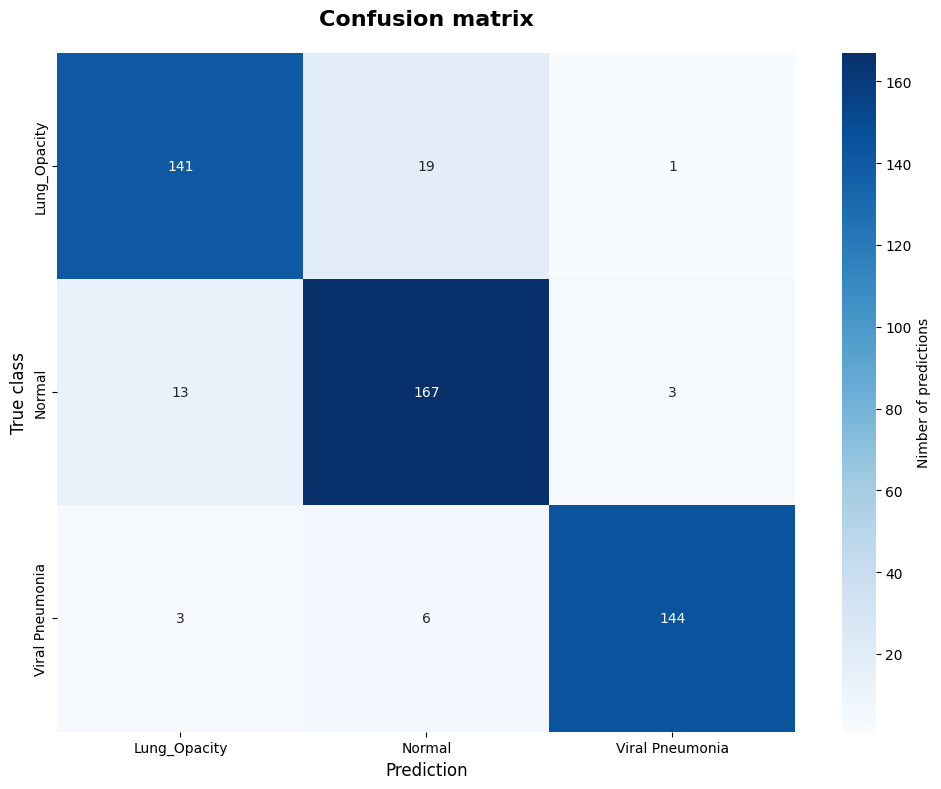

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with autocast(device):
            outputs = model(images)
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.class_names, digits=4))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.class_names, 
            yticklabels=dataset.class_names,
            cbar_kws={'label': 'Nimber of predictions'})
plt.title('Confusion matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.tight_layout()
plt.show()

# Resulting attention map

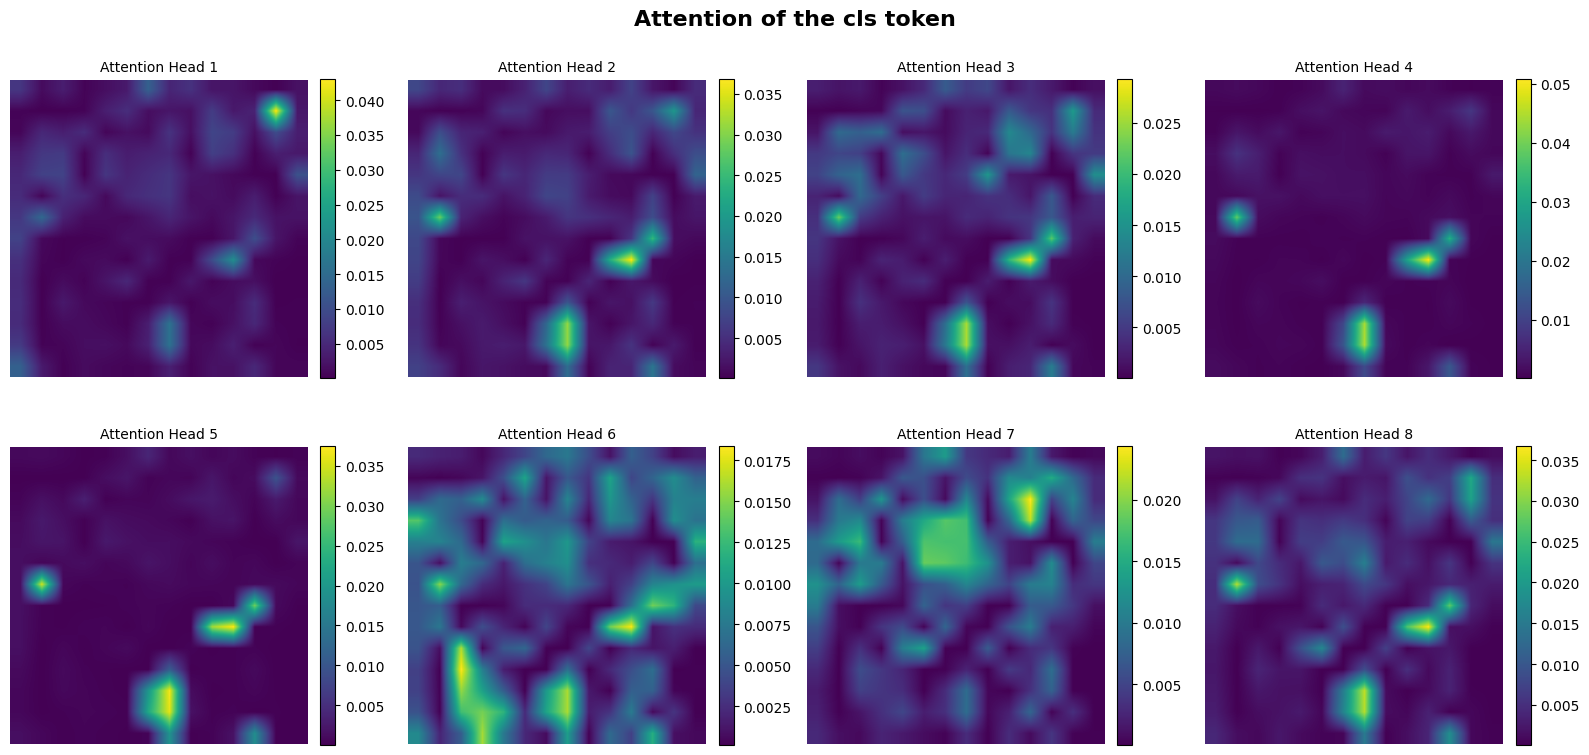

In [16]:
import torch.nn.functional as F

def get_attention_maps(model, image):
    model.eval()
    attention_maps = []

    def hook_fn(module, input, output):
        x = input[0]
        
        if not module.batch_first:
            x = x.permute(1, 0, 2)
            
        B, N, C = x.shape
        
        qkv = F.linear(x, module.in_proj_weight, module.in_proj_bias)
        
        num_heads = module.num_heads
        head_dim = C // num_heads
        
        qkv = qkv.reshape(B, N, 3, num_heads, head_dim)
        
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * (head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        
        attention_maps.append(attn.detach().cpu())

    hooks = []
    for layer in model.encoder.layers:
        hooks.append(layer.self_attention.register_forward_hook(hook_fn))

    with torch.no_grad():
        _ = model(image)

    for hook in hooks:
        hook.remove()

    return attention_maps


first_image, first_label = dataset[0]
first_image_tensor = torch.from_numpy(first_image).permute(2, 0, 1).float() / 255.0
first_image_tensor = train_transform(first_image_tensor)
first_image_tensor = first_image_tensor.unsqueeze(0).to(device)


attention_maps = get_attention_maps(model, first_image_tensor)

last_attn = attention_maps[-1][0]
n_patches = int(np.sqrt(last_attn.shape[1] - 1))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, last_attn.shape[0])):
    attn_weights = last_attn[i, 0, 1:].reshape(n_patches, n_patches).numpy()
    
    im = axes[i].imshow(attn_weights, cmap='viridis', interpolation='bilinear')
    axes[i].set_title(f'Attention Head {i+1}', fontsize=10)
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.suptitle('Attention of the cls token', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

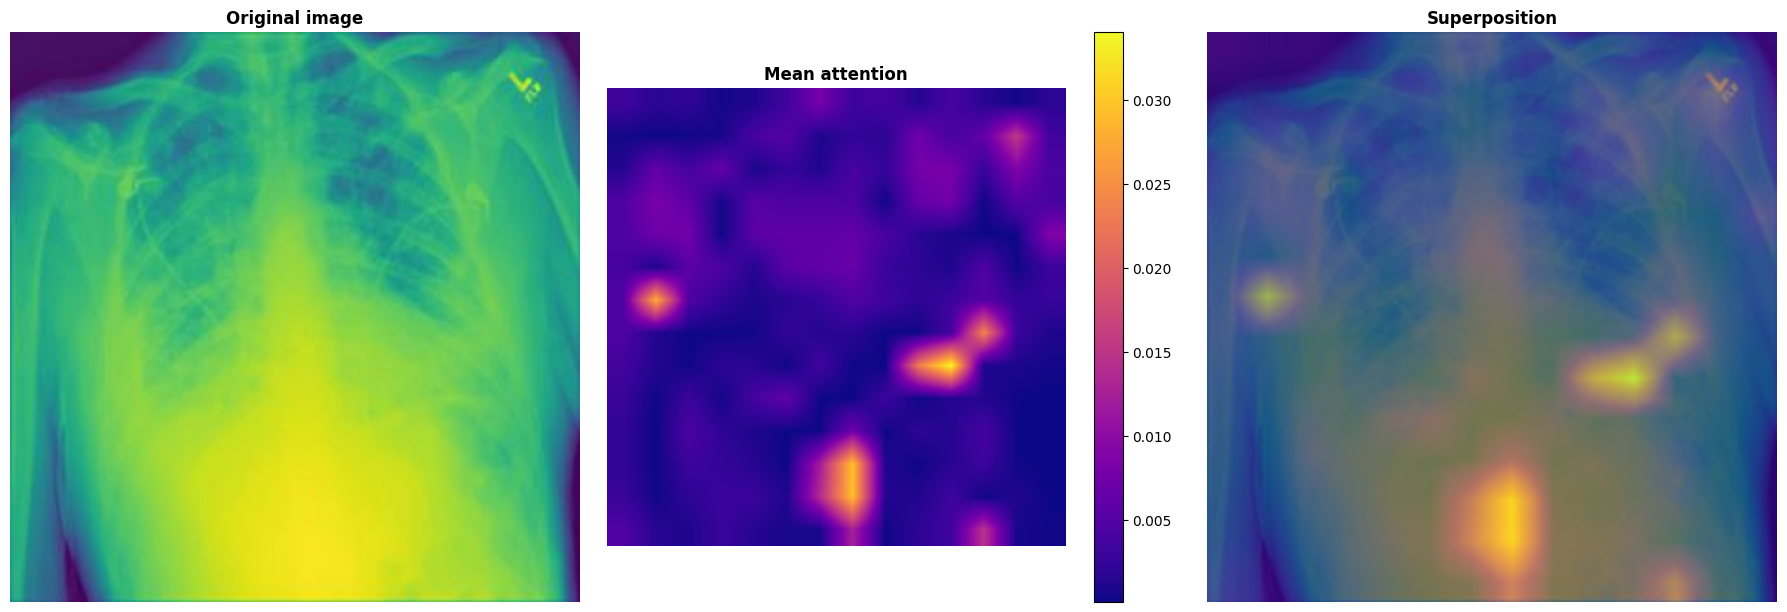

In [17]:
mean_attn = last_attn[:, 0, 1:].mean(dim=0).reshape(n_patches, n_patches).numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(first_image)
ax1.set_title(f'Original image', fontsize=12, fontweight='bold')
ax1.axis('off')

im2 = ax2.imshow(mean_attn, cmap='plasma', interpolation='bilinear')
ax2.set_title('Mean attention', fontsize=12, fontweight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2)

ax3.imshow(first_image)
attn_resized = cv2.resize(mean_attn, (first_image.shape[1], first_image.shape[0]))
ax3.imshow(attn_resized, cmap='plasma', alpha=0.5, interpolation='bilinear')
ax3.set_title('Superposition', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.show()